## Imports

In [1]:
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from data import Record, RecordBuilder
from signal_generator import generate_ecg
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
import scipy as sp
import pandas as pd

## Code

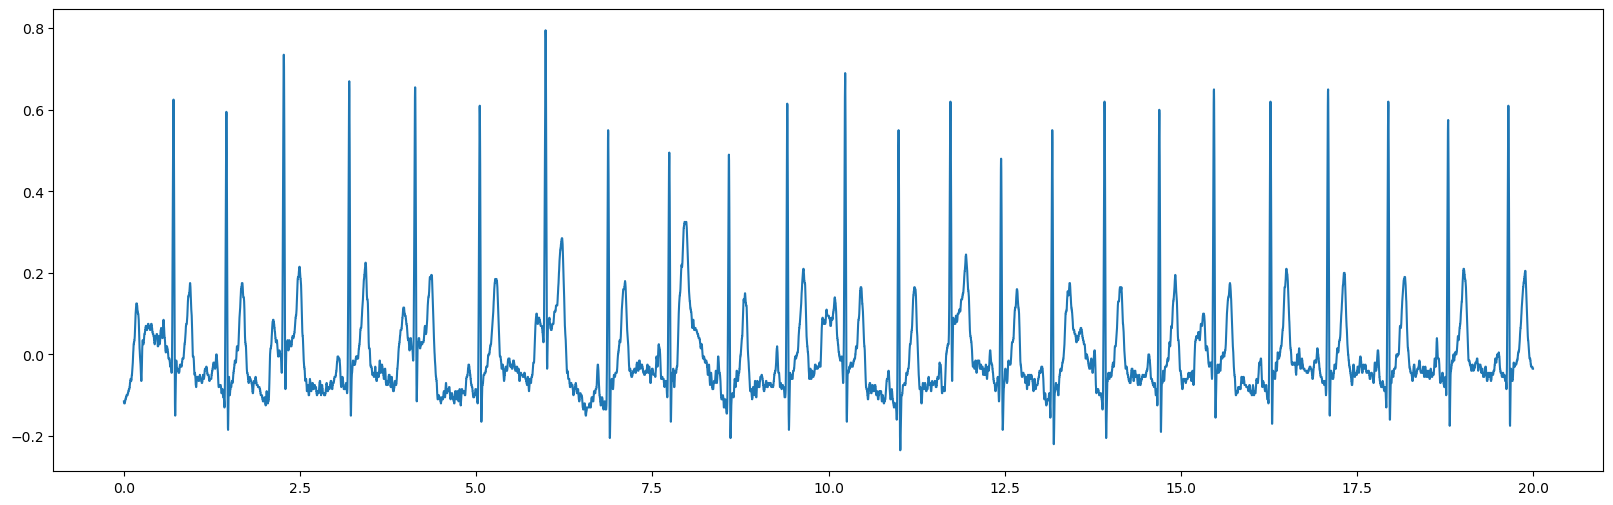

In [2]:
record = RecordBuilder.fetch_record(1, 1)
plt.figure(figsize=(20,6))
plt.plot(np.arange(record.clean_signal.shape[0]) / record.sampling_frequency, record.clean_signal)
plt.show()

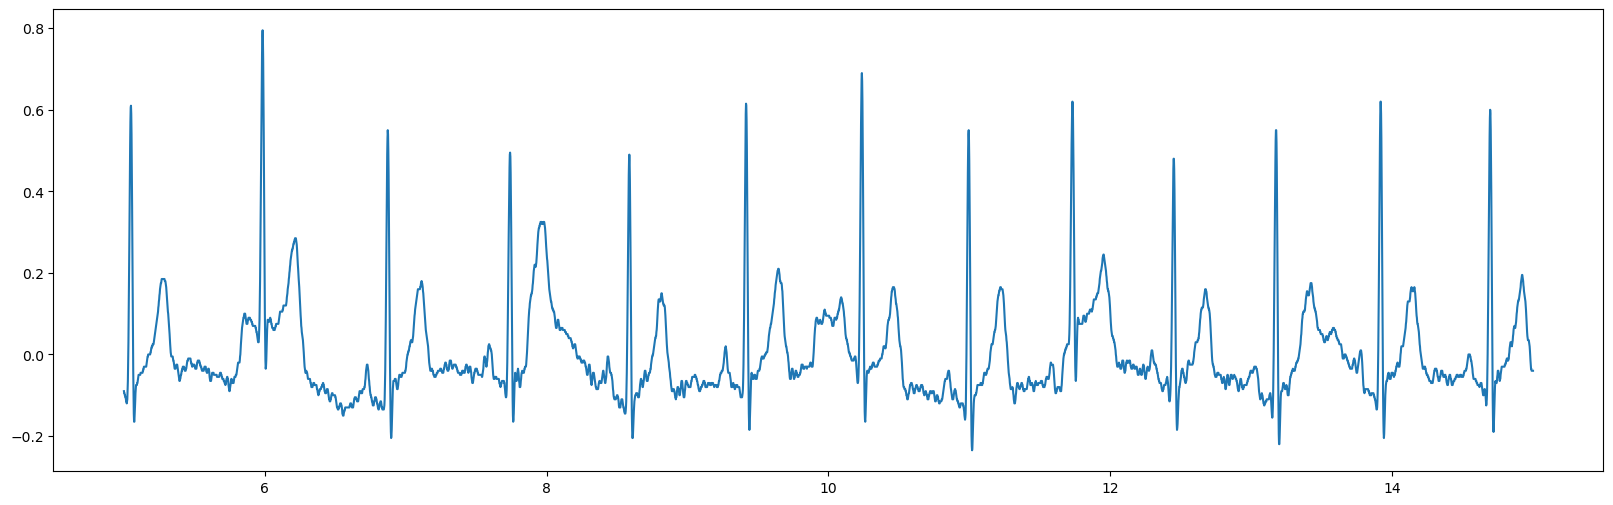

In [ ]:
times, signal = record.get_segment(5.0, 10.0)
plt.figure(figsize=(20,6))
plt.plot(times, signal)
plt.show()

uh?
uh?


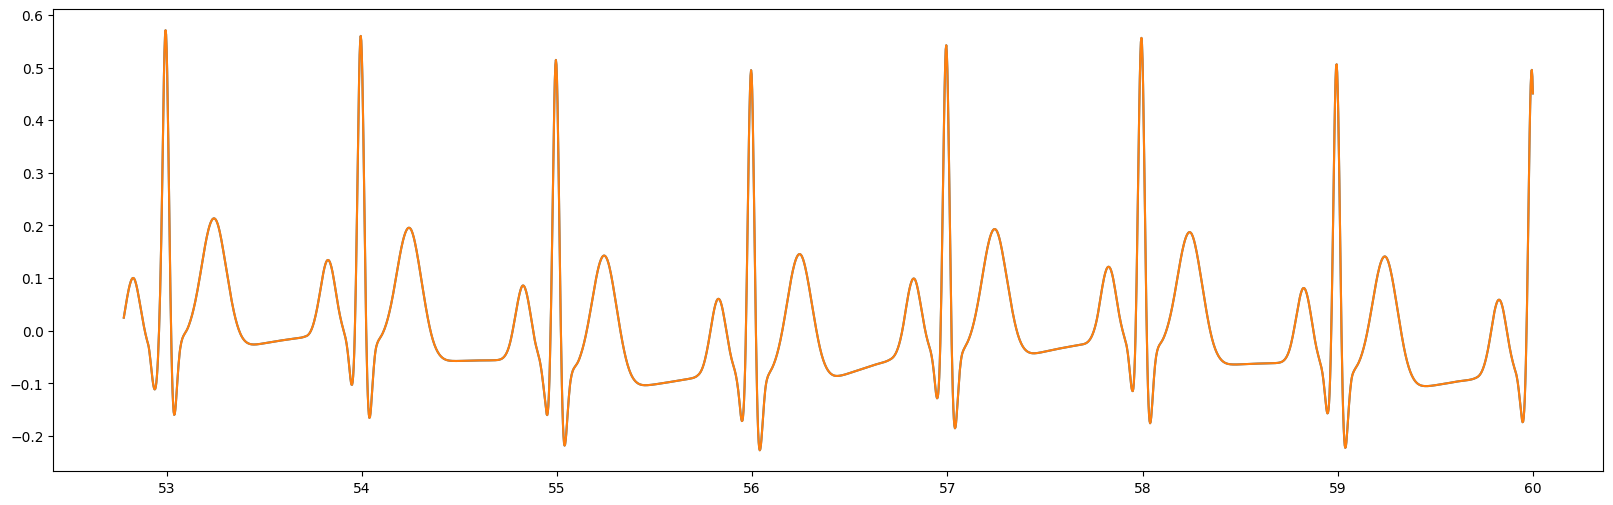

In [4]:
t1, s1 = generate_ecg(heart_beat_mode="constant")
t2, s2 = generate_ecg(heart_beat_mode="constant")
plt.figure(figsize=(20,6))
plt.plot(t1[19000:], s1[19000:])
plt.plot(t2[19000:], s2[19000:])
plt.show()

## Going through the signals

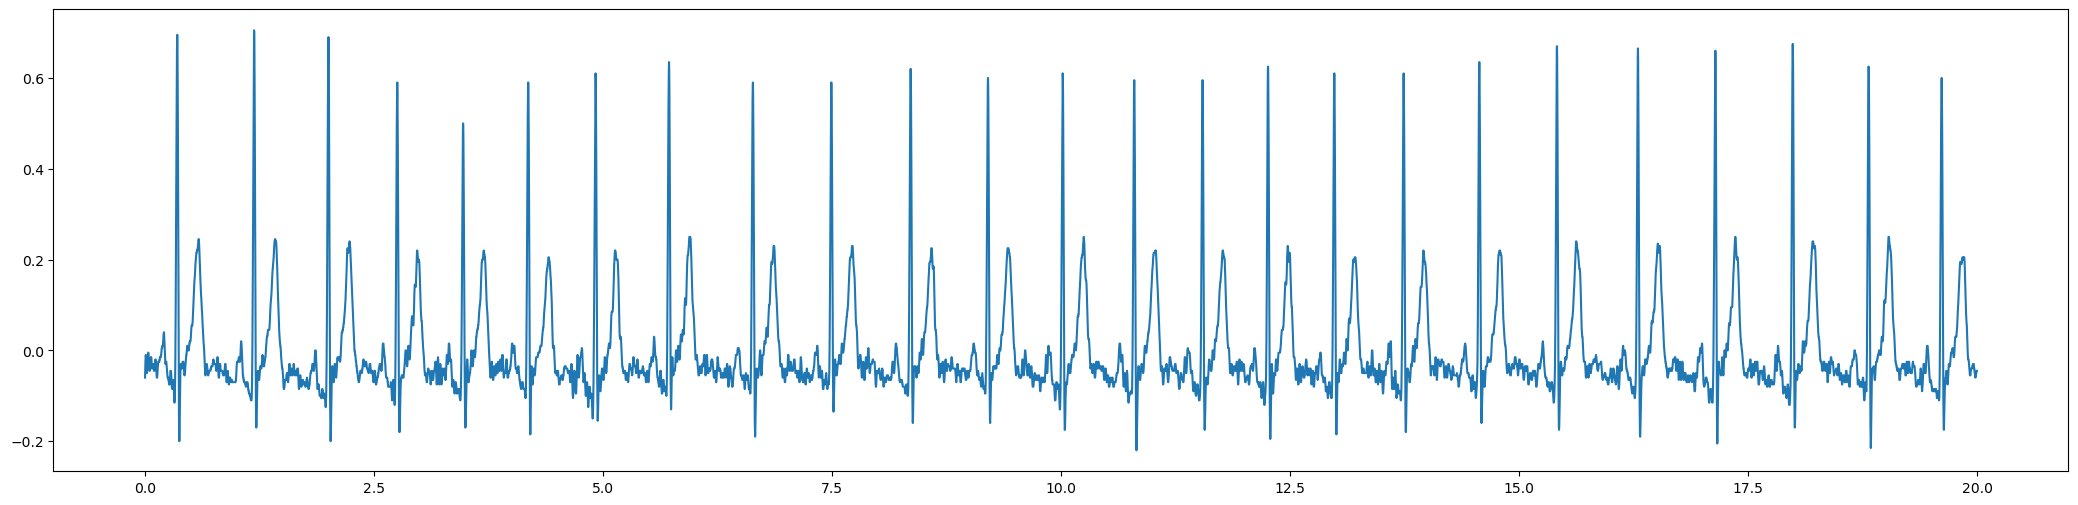

In [ ]:
record = RecordBuilder.fetch_record(1, 2)
plt.figure(figsize=(26,6))
plt.plot(np.arange(record.clean_signal.shape[0]) / record.sampling_frequency, record.clean_signal)
plt.show()

In [ ]:
fig = plt.figure(figsize=(26,8))
ax = fig.add_subplot()
plt.close(fig)

@widgets.interact(person=(1,54,1), sample=(1,20,1))
def update_plot(person: int, sample: int):
    clear_output()
    record = None
    ax.clear()
    try: 
        record = RecordBuilder.fetch_record(person, sample)
    except:
        pass
    if record is not None:
        ax.set_title(f"Sample {person}.{sample}")
        ax.plot(np.arange(record.clean_signal.shape[0]) / record.sampling_frequency, record.clean_signal)
    else:
        ax.set_title("Sample does not exist")
        ax.plot(np.arange(10), np.arange(10))
    fig.canvas.draw()
    # plt.show()
    _=display(fig)

# person_slider = widgets.IntSlider(min=1, max=54, step=1, value=1, description="Person")
# sample_slider = widgets.IntSlider(min=1, max=20, step=1, value=1, description="Sample")
# interactive = widgets.interactive(update_plot, person=person_slider, sample=sample_slider)

# clear_output()
# display(interactive)

## Preparing dataset

In [34]:
# Using heart_beat_mode = "constant" makes the generation fairly deterministic
# So following columns should identify particular signal
# Duration will be fixed to 5 seconds,
# this will give enough peaks to compare with minimal heart beat divergence
# and will help with normalizing cross correlation.
# As for eyeballed match I will rank it from 0 to 5
cwd = os.getcwd()
file_path = os.path.join(os.path.dirname(cwd), "Data", "signals.csv")
df = None
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    columns = ["person", "sample", "fs", "start_time", "sim_hr", "sim_offset", "mse", "cross_corr", "eyeballed_match"]
    df = pd.DataFrame(columns=columns)

In [147]:
fig, ax = plt.subplots(figsize=(16,6))
plt.close()

def update_plot(person: int, sample: int, time: float, duration: float):
    clear_output()
    record = None
    ax.clear()
    try: 
        record = RecordBuilder.fetch_record(person, sample)
    except:
        pass
    if record is not None:
        ax.set_title(f"Sample {person}.{sample}")
        time, signal = record.get_segment(time, duration)
        ax.plot(time, signal)
    else:
        ax.set_title("Sample does not exist")
        ax.plot(np.arange(10), np.arange(10))
    # plt.show()
    # fig.canvas.draw()
    display(fig)
    return None

person_slider = widgets.IntSlider(min=1, max=54, step=1, value=1, description="Person")
sample_slider = widgets.IntSlider(min=1, max=20, step=1, value=1, description="Sample")
time_slider = widgets.FloatSlider(min=0.0, max=20.0, step=0.1, value=0.0, description="Time")
window_slider = widgets.FloatSlider(min=1.0, max=5.0, step=0.05, value=5.0, description="Duration")
interactive = widgets.interact(update_plot, person=person_slider, sample=sample_slider, time=time_slider, duration=window_slider)
_=display(interactive)

interactive(children=(IntSlider(value=1, description='Person', max=54, min=1), IntSlider(value=1, description=…

<function __main__.update_plot(person: int, sample: int, time: float, duration: float)>

In [148]:
person_value = person_slider.value
sample_value = sample_slider.value
time_value = time_slider.value
duration_value = window_slider.value
print(f"Sample:\t\t\t {person_value}-{sample_value}")
print(f"Time window:\t\t {time_value} - {time_value + duration_value}")
print("------------------------------------------------------------------")
record = RecordBuilder.fetch_record(person_value, sample_value)
time, signal = record.get_segment(time_value, duration_value)
peaks, info = sp.signal.find_peaks(record.clean_signal, height=0.4)
smin, smax = np.min(signal), np.max(signal)
smean, sstd = np.mean(signal), np.std(signal)
print(f"Signal value range:\t ({smin}, {smax})")
print(f"Signal mean:\t\t {smean:.4f}")
print(f"Signal std:\t\t {sstd:.4f}")
print(f"Heart rate:\t\t {len(peaks) / (record.duration / 60.0)}")

Sample:			 53-4
Time window:		 9.5 - 14.5
------------------------------------------------------------------
Signal value range:	 (-0.265, 0.84)
Signal mean:		 -0.0023
Signal std:		 0.1254
Heart rate:		 90.0


In [149]:
fig, axs = plt.subplots(nrows = 2, figsize=(16,6))
plt.close(fig)

offset_slider = widgets.FloatSlider(min=0.0, max=60.0, step=0.01, value=0.0)
hr_slider = widgets.FloatSlider(min=30.0, max=120.0, step=0.25, value=60.0)

def update_simulation(hr: float, offset: float):
    clear_output()
    sim_times, sim_sig = generate_ecg(fs = record.sampling_frequency, heart_beat=hr, heart_beat_mode="constant", scale_low=smin, scale_high=smax, scale_mean=smean, scale_std=sstd)
    start = int(offset * record.sampling_frequency)
    end = min(int((offset + duration_value)*record.sampling_frequency), len(sim_sig))
    axs[0].clear()
    axs[1].clear()
    axs[0].plot(sim_times[start:end], sim_sig[start:end])
    axs[1].plot(time, signal)
    # plt.show()
    fig.canvas.draw()
    display(fig)
    return None


interactive = widgets.interact(update_simulation, hr=hr_slider, offset=offset_slider)
_ = display(interactive)

interactive(children=(FloatSlider(value=60.0, description='hr', max=120.0, min=30.0, step=0.25), FloatSlider(v…

<function __main__.update_simulation(hr: float, offset: float)>

In [ ]:
hr_value = hr_slider.value
offset_value = offset_slider.value
sim_times, sim_sig = generate_ecg(fs = record.sampling_frequency, heart_beat=hr_value, heart_beat_mode="constant", scale_low=smin, scale_high=smax, scale_mean=smean, scale_std=sstd)
start = int(offset_value * record.sampling_frequency)
end = min(int((offset_value + duration_value)*record.sampling_frequency), len(sim_sig))
sim_sig = sim_sig[start:end]

mse = np.mean((sim_sig - signal)*(sim_sig - signal))
correlation = sp.signal.correlate(sim_sig, signal, mode="same")
s_corr = np.max(correlation / np.sqrt(np.sum(signal**2) * np.sum(sim_sig**2)))
eye_match = 2

columns = []
row = {
    "person": person_value, 
    "sample": sample_value,
    "fs": record.sampling_frequency,
    "start_time": time_value,
    "sim_hr": hr_value,
    "sim_offset": offset_value,
    "mse": float(mse),
    "cross_corr": float(s_corr),
    "eyeballed_match": eye_match
}
print(row)
# df.loc[df.shape[0]] = row

{'person': 53, 'sample': 4, 'fs': 500, 'start_time': 9.5, 'sim_hr': 90.0, 'sim_offset': 0.84, 'mse': 0.03473158075120894, 'cross_corr': 0.4640220043953321, 'eyeballed_match': 2}


In [152]:
print(df.to_string())

    person  sample   fs  start_time  sim_hr  sim_offset       mse  cross_corr  eyeballed_match
0        1       1  500         2.6   65.50       14.03  0.026078    0.451530                2
1        1       4  500         3.0   74.50        0.33  0.019559    0.627550                3
2        1      15  500         2.3   76.00       17.81  0.020131    0.622367                3
3        2       7  500         0.8   79.00       10.95  0.018244    0.315369                1
4        3       5  500         0.1   69.00        0.34  0.049128    0.289706                2
5       10       1  500         0.7   84.00        1.02  0.026227    0.515692                2
6        1       5  500         0.8   81.00        4.78  0.053592    0.429565                3
7       12       1  500         0.8   89.00        0.34  0.136360    0.214428                1
8       24       4  500         9.6   64.00        0.46  0.050644    0.455943                3
9       25       5  500         5.2   69.00       

In [153]:
df.to_csv(file_path)

## Crete csv

Sample 1.1 - Heart rate: 72.85 bpm


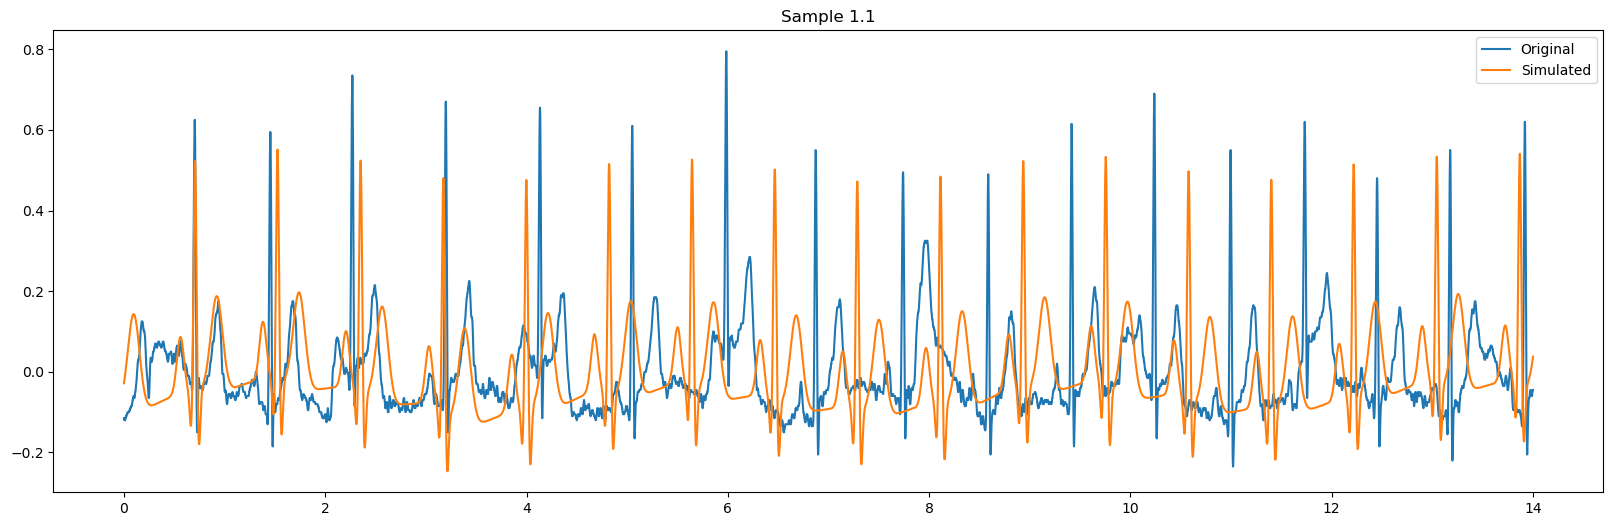

Sample 1.4 - Heart rate: 79.63 bpm


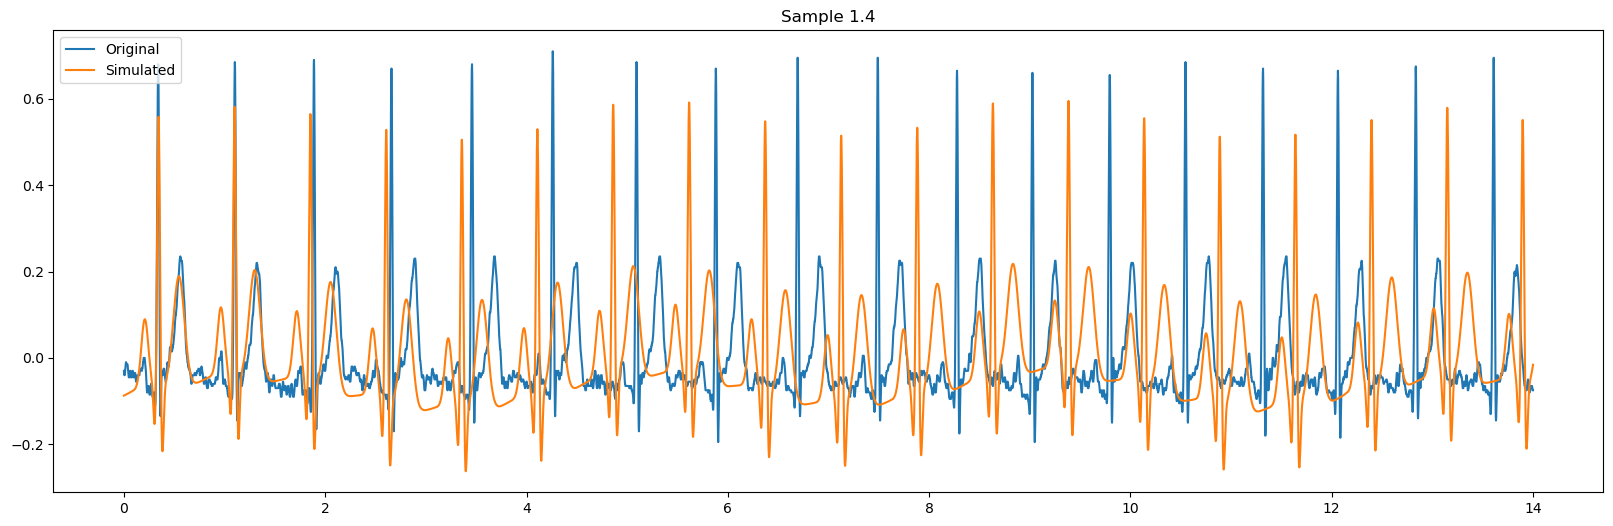

Sample 1.15 - Heart rate: 75.21 bpm


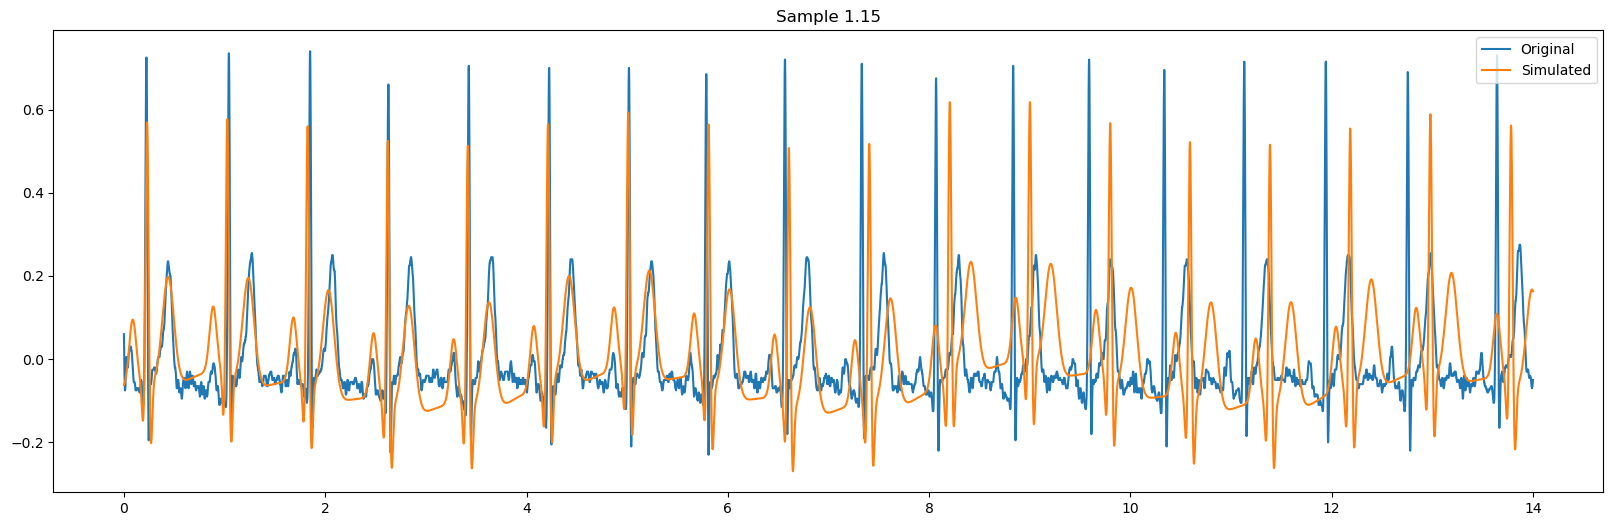

Sample 2.3 - Heart rate: 27.96 bpm


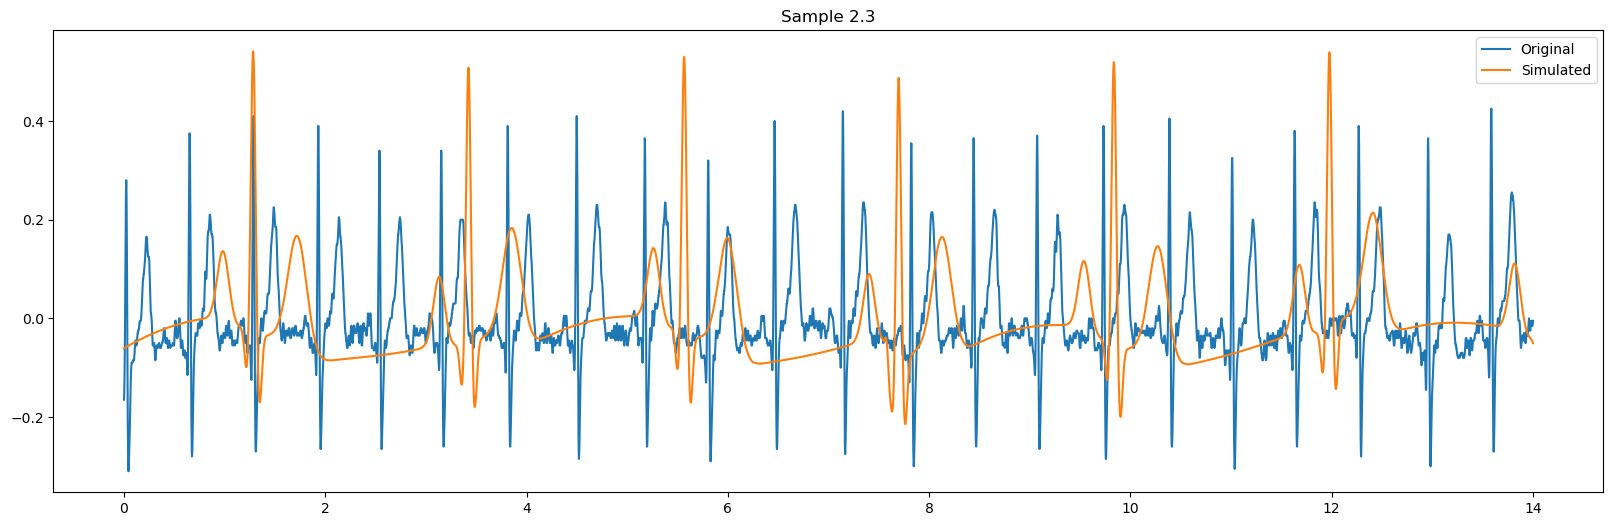

Sample 2.7 - Heart rate: 72.00 bpm


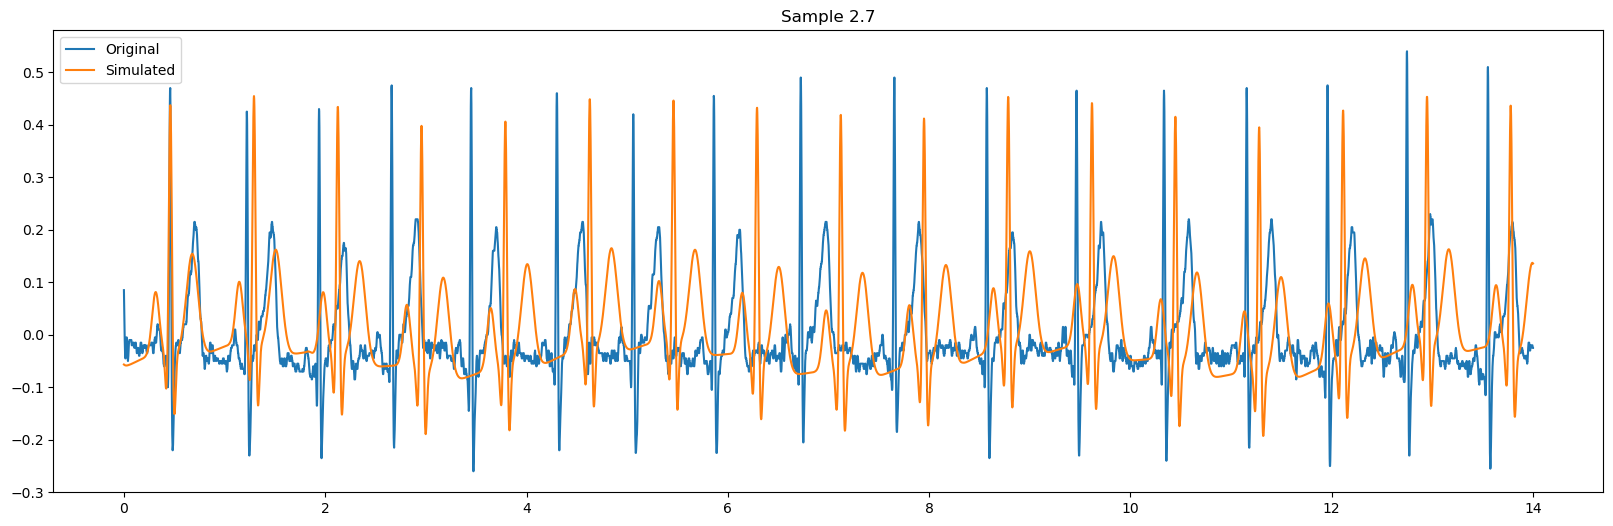

Sample 2.20 - Heart rate: 62.23 bpm


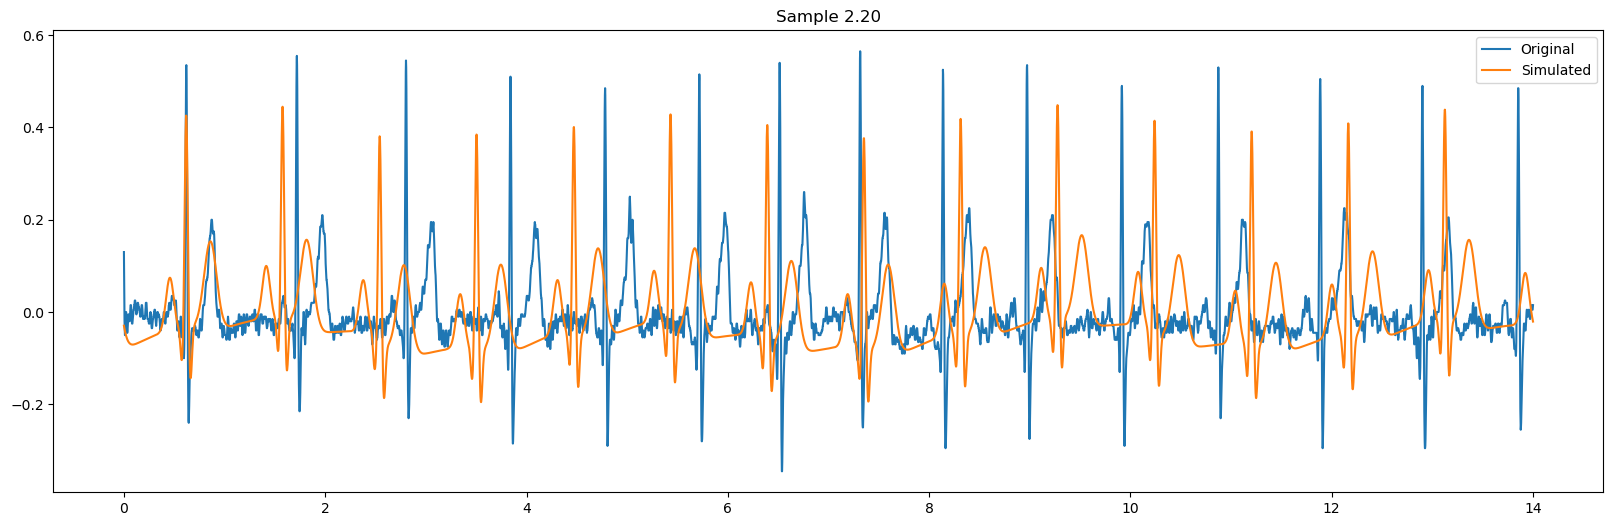

Sample 3.5 - Heart rate: 69.22 bpm


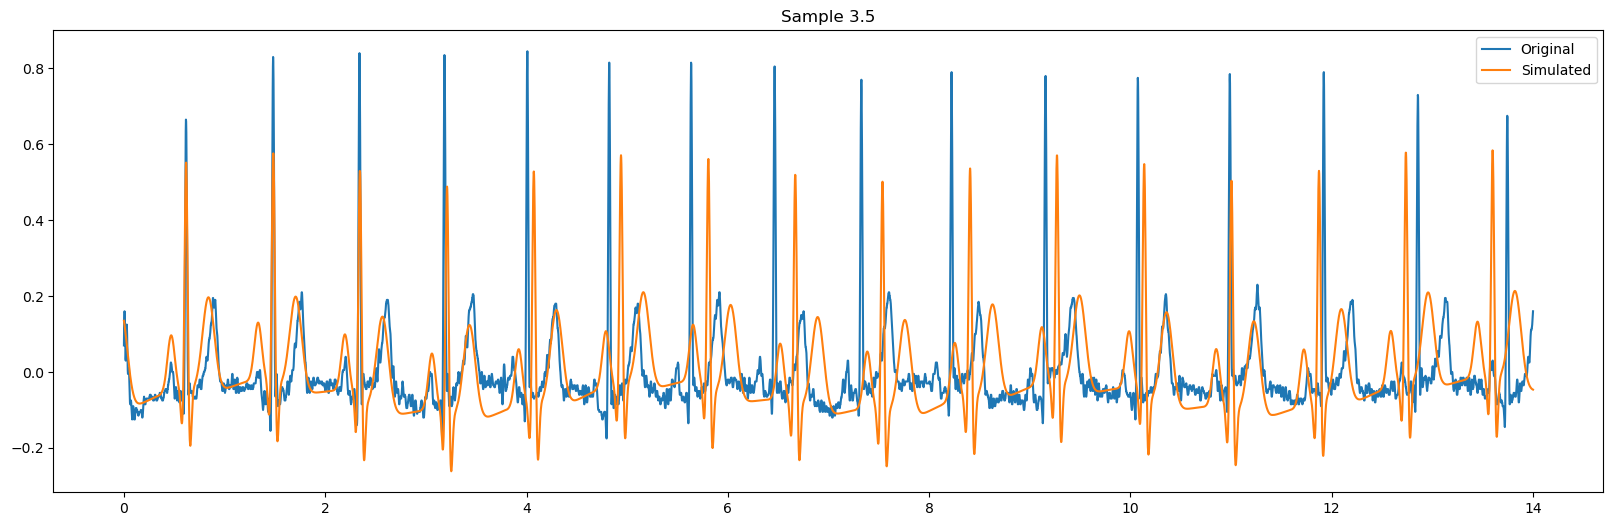

Sample 8.2 - Heart rate: 92.25 bpm


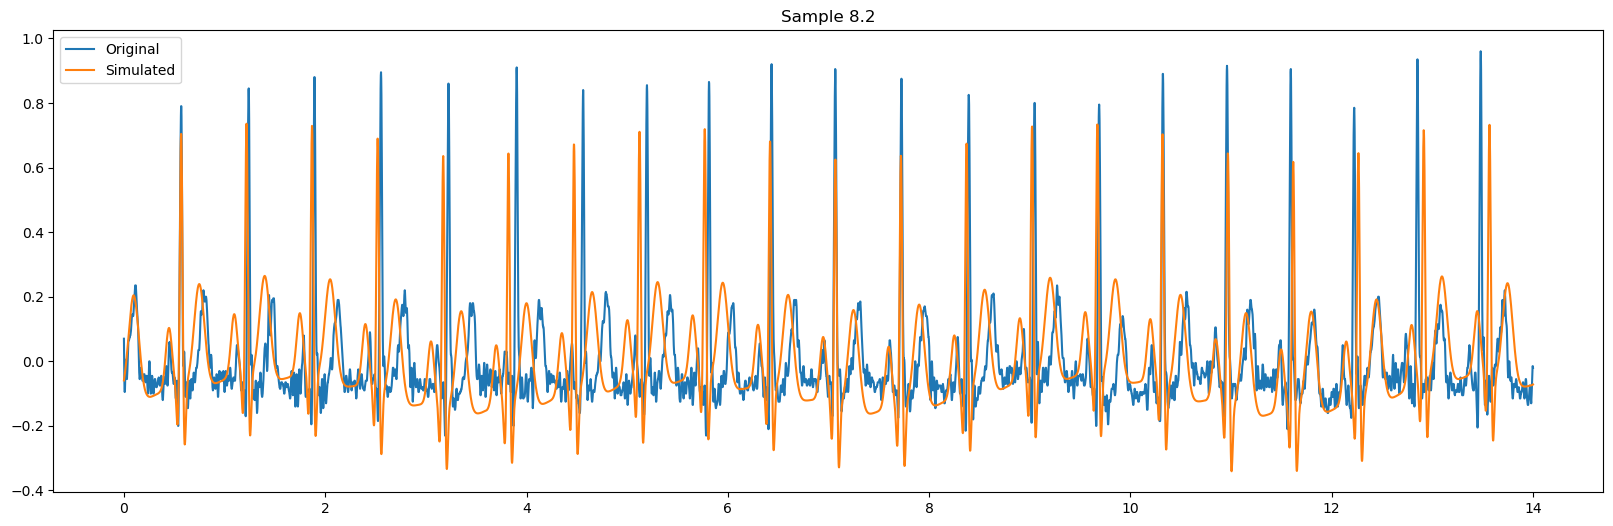

Sample 10.1 - Heart rate: 84.31 bpm


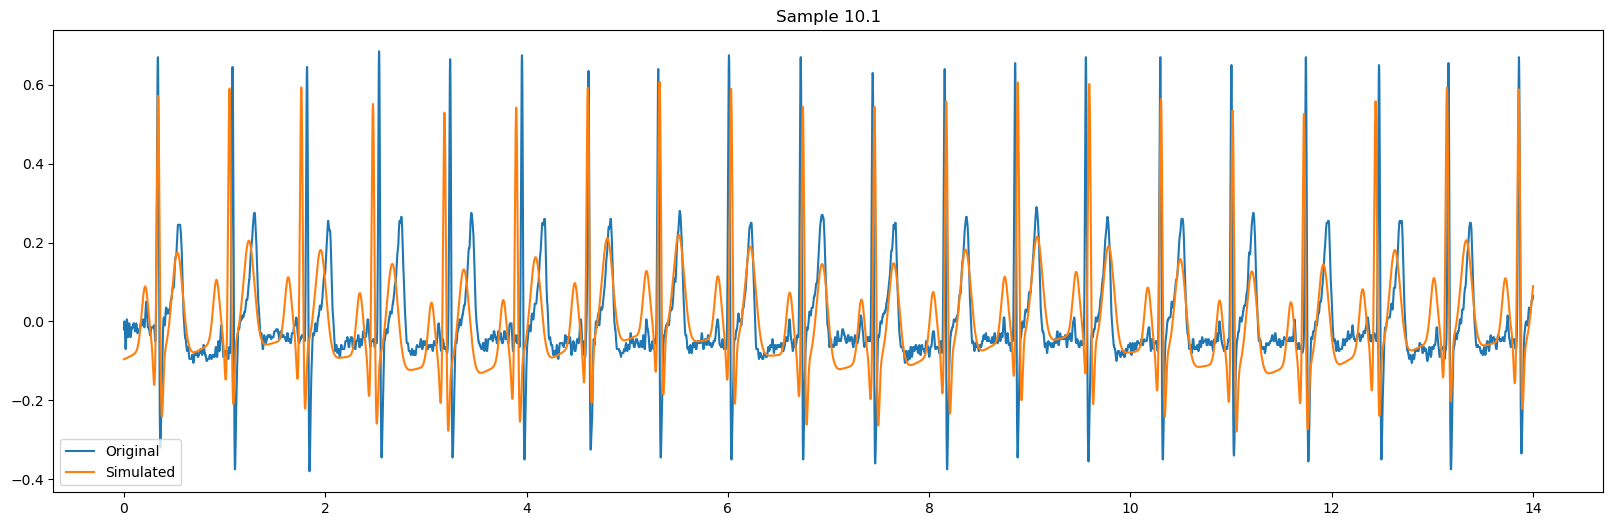

Sample 10.5 - Heart rate: 71.10 bpm


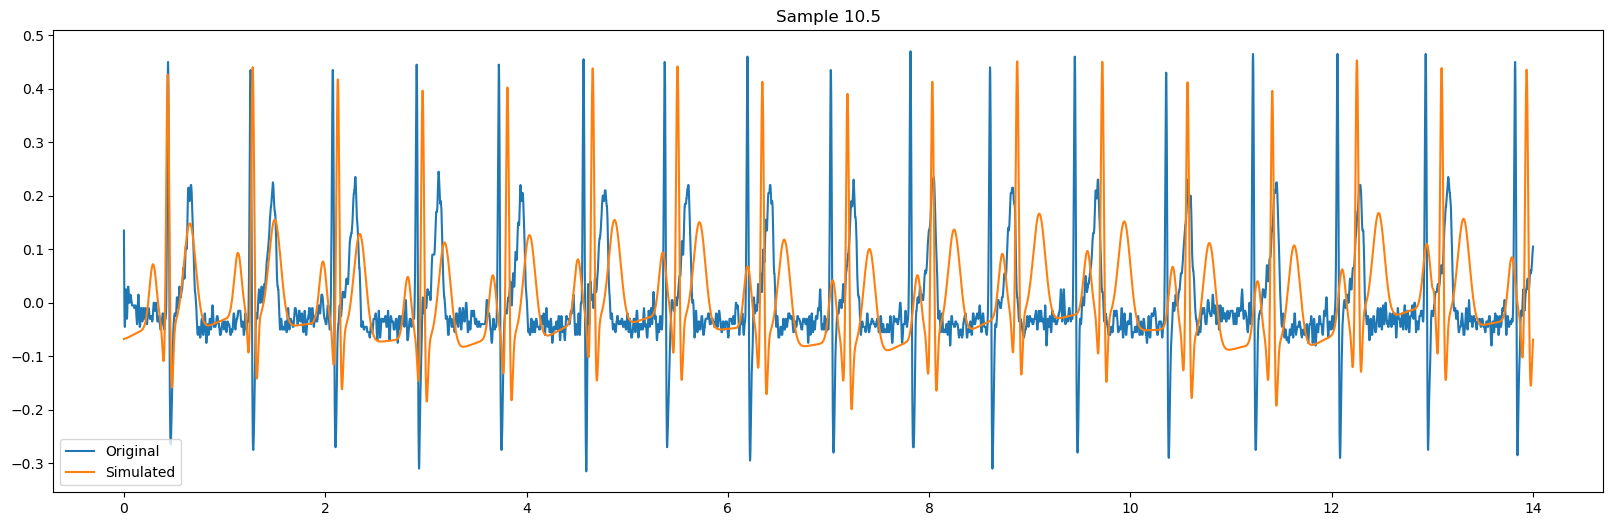

Sample 12.1 - Heart rate: 87.41 bpm


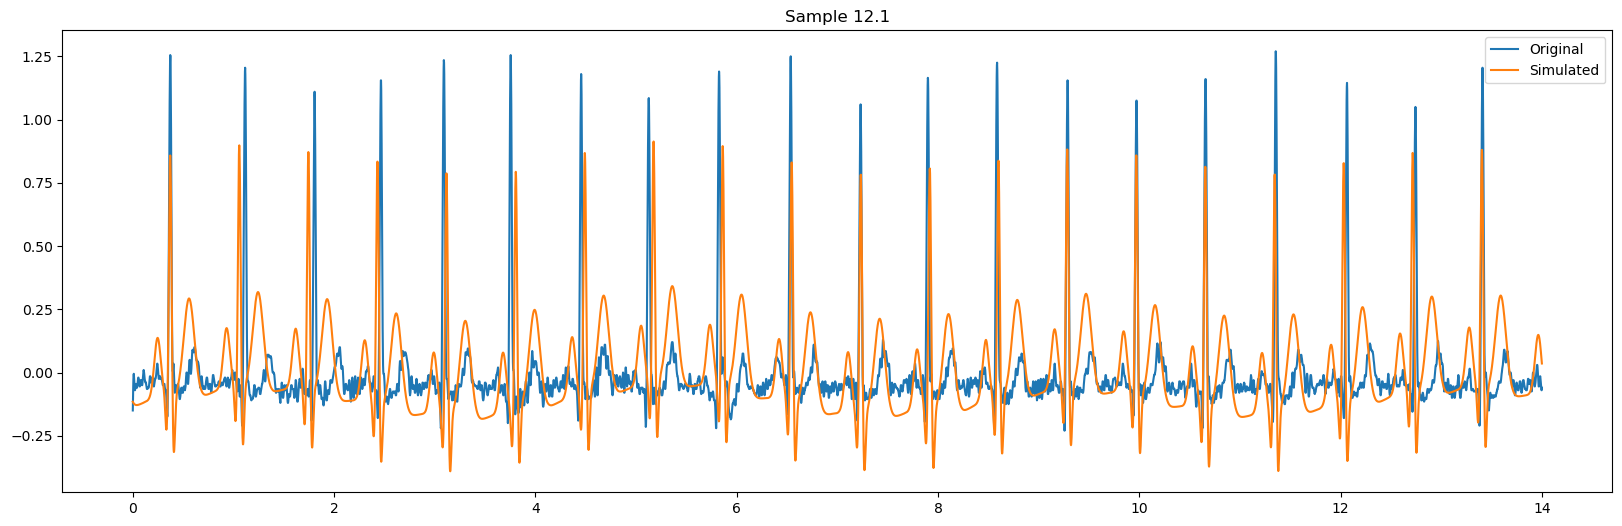

Sample 16.1 - Heart rate: 87.57 bpm


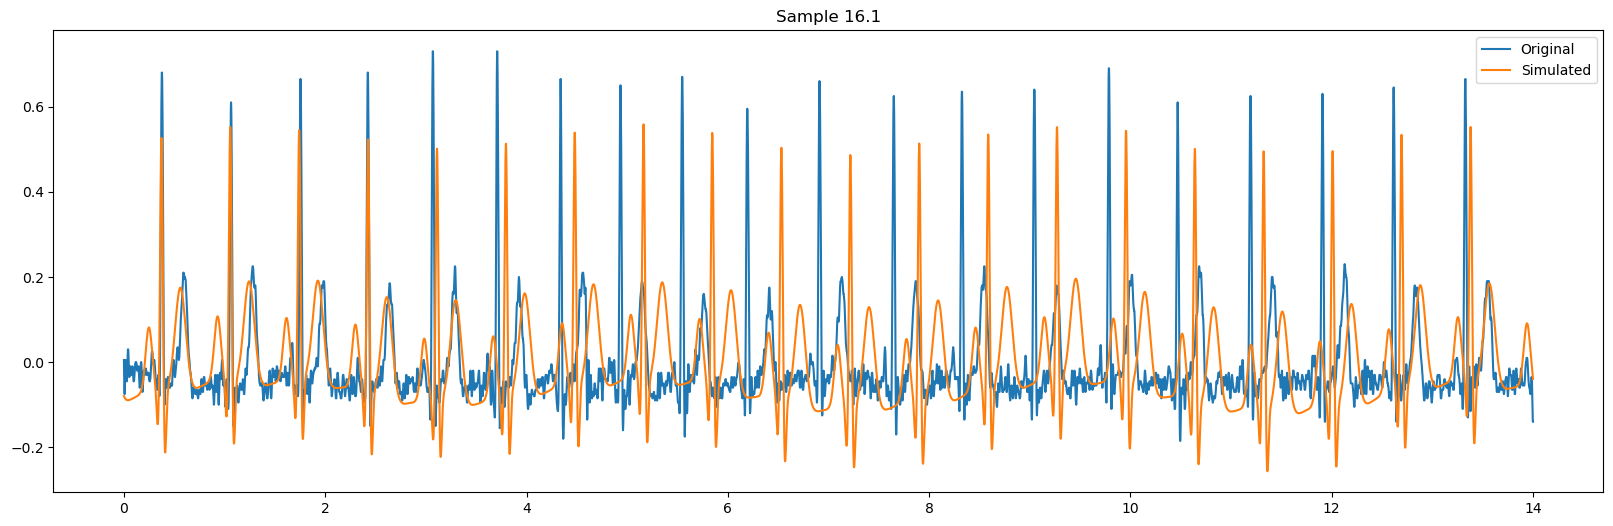

Sample 17.2 - Heart rate: 67.24 bpm


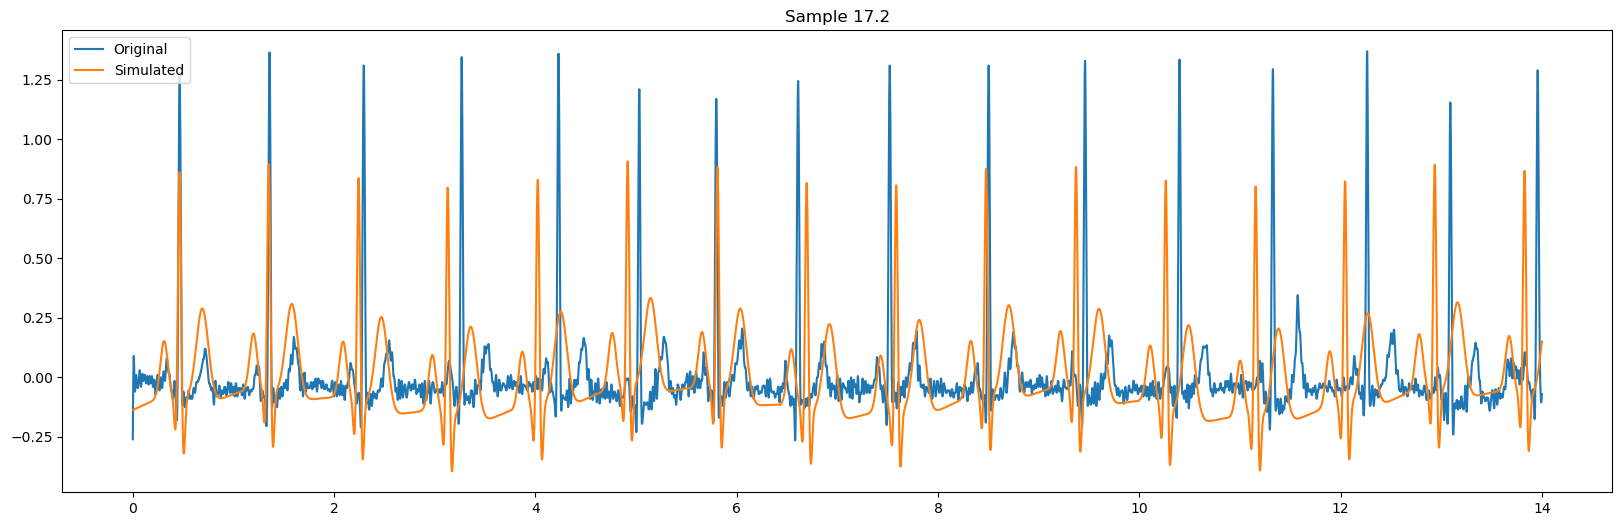

Sample 23.1 - Heart rate: 59.14 bpm


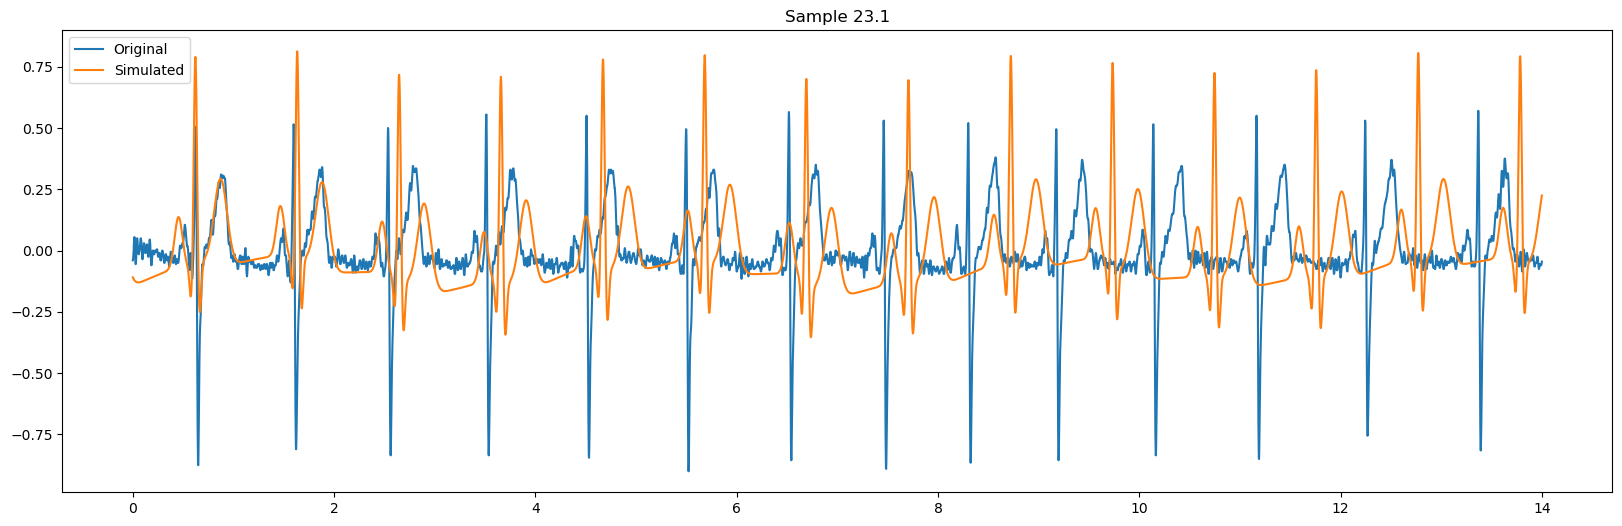

Sample 24.4 - Heart rate: 64.16 bpm


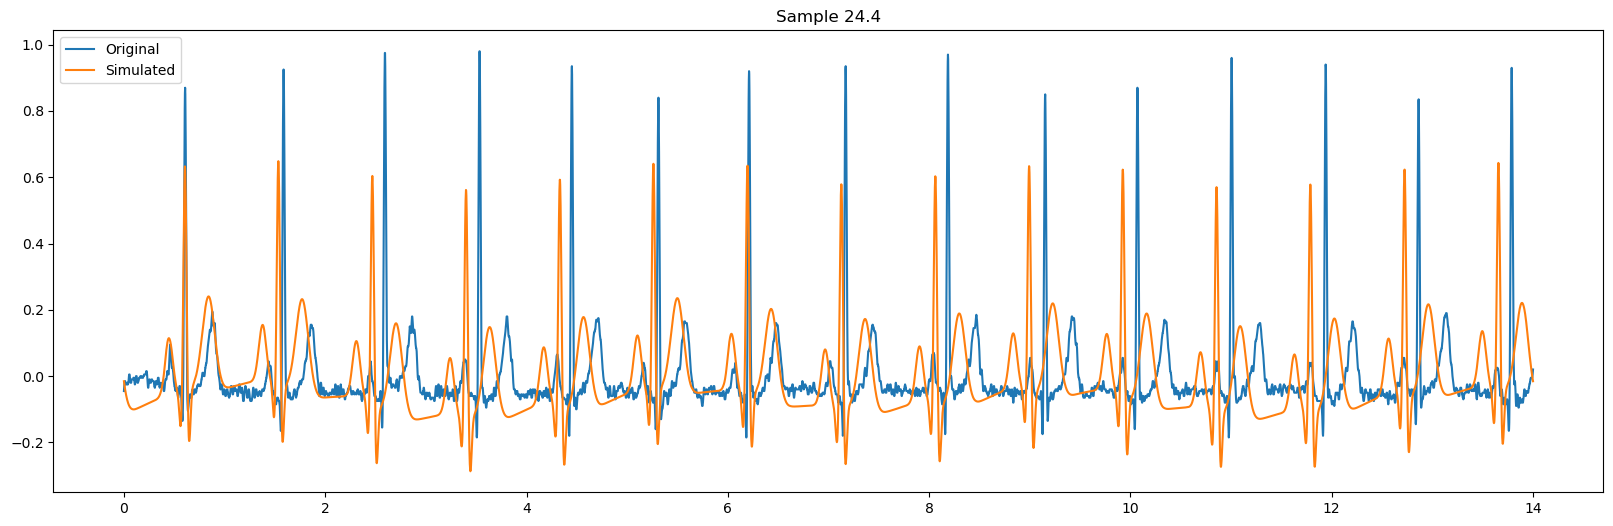

Sample 25.5 - Heart rate: 68.61 bpm


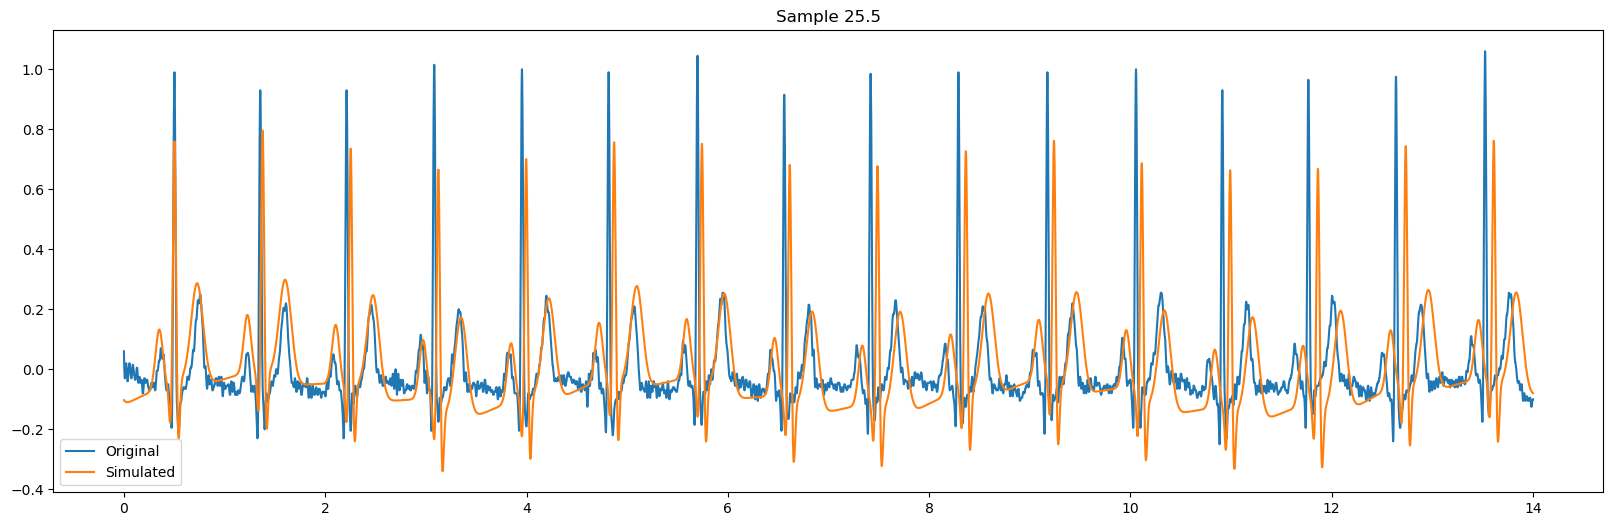

Sample 26.4 - Heart rate: 71.56 bpm


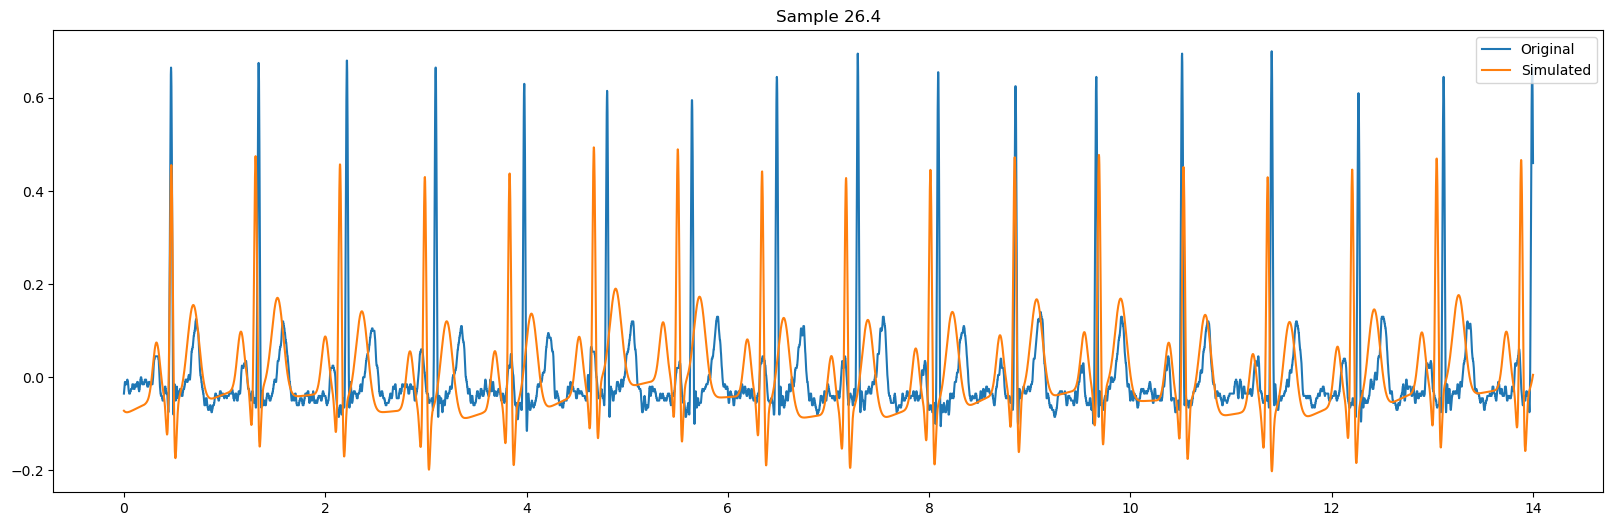

In [ ]:
persons = [1,1,1,2,2,2,3,8,10,10,12,16,17,23,24,25,26]
samples = [1,4,15,3,7,20,5,2,1,5,1,1,2,1,4,5,4]

for person, sample in zip(persons, samples):
    record = RecordBuilder.fetch_record(person, sample)
    times, signal = record.get_segment(0.0, 20.0)

    peaks, _ = sp.signal.find_peaks(signal, height=0.4)

    #hbeats = len(peaks) / (times[-1] - times[0]) * 60.0 # TODO: opravit!

    rr_intervals = np.diff(peaks) / record.sampling_frequency  # rozdíly v sekundách
    mean_rr = np.mean(rr_intervals)
    hbeats = 60 / mean_rr  # bpm

    print(f"Sample {person}.{sample} - Heart rate: {hbeats:.2f} bpm")

    smin, smax = np.min(signal), np.max(signal)
    smean, sstd = np.mean(signal), np.std(signal)
    peak = times[peaks[0]]

    offset = (60/hbeats) - peak
    sim_times, sim_sig = generate_ecg(fs = record.sampling_frequency, heart_beat=hbeats, scale_low=smin, scale_high=smax, scale_mean=smean, scale_std=sstd)

    start = int(offset * record.sampling_frequency)
    end = min(int((offset + record.duration)*record.sampling_frequency), len(sim_sig))
    
    signal2 = sim_sig[start:end]

    stop = 7000

    plt.figure(figsize=(20,6))
    plt.plot(times[:stop], signal[:stop], label="Original")
    plt.plot(times[:stop], signal2[:stop], label="Simulated")
    plt.title(f"Sample {person}.{sample}")
    plt.legend()
    plt.show()